In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import openpnm as op
import networkx

Demonstration of solving a simple network

# Packing Visualisation
A very simple packing to demonstrait the concept

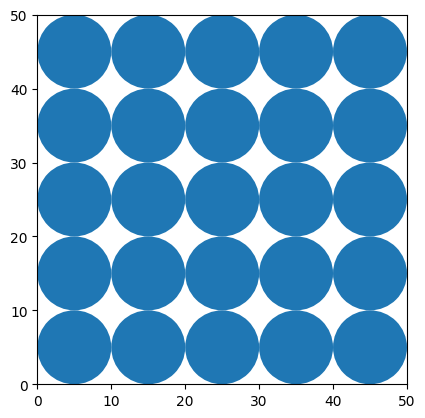

In [2]:
radius = 5
domain_width = 50
domain_height = 50

fig, ax = plt.subplots()

for i in np.arange(0, domain_width, radius*2):
    for j in np.arange(0, domain_height, radius*2):
        c = patches.Circle((i+radius,j+radius), radius)
        ax.add_patch(c)

ax.set_xlim(0,domain_width)
ax.set_ylim(0,domain_height)
ax.set_aspect('equal')

nx = int(domain_width//(2*radius))
ny = int(domain_height//(2*radius))
plt.savefig("packing.pdf")

# Network Representation

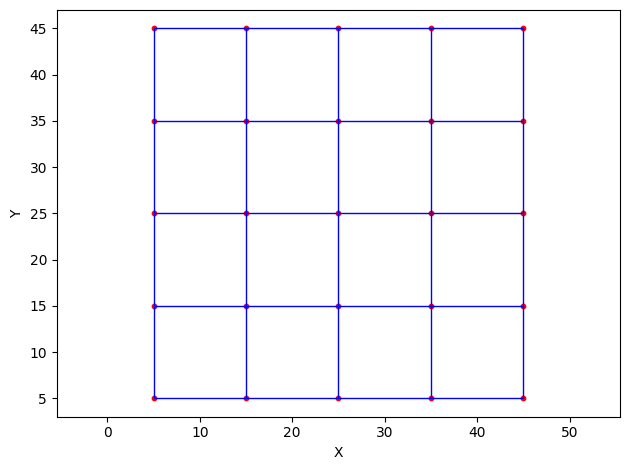

In [3]:
pn = op.network.Cubic(shape=[nx, ny], spacing=2*radius)
ax = op.visualization.plot_coordinates(pn)
ax = op.visualization.plot_connections(pn, ax=ax)
plt.savefig("network.pdf")

From the network create a oriented incident matrix. Since the original graph is not directed this is not unique.

/tmp/ipykernel_901550/841819150.py:1: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = networkx.incidence_matrix(op.io.network_to_networkx(pn), oriented=True).todense().T


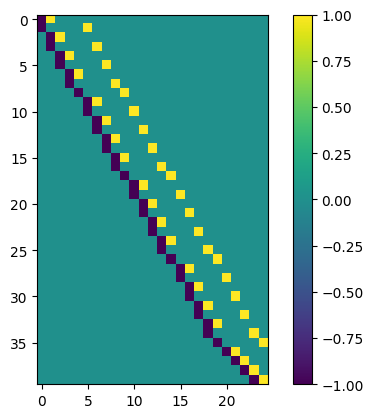

In [4]:
A = networkx.incidence_matrix(op.io.network_to_networkx(pn), oriented=True).todense().T
plt.imshow(A)
plt.colorbar()
plt.savefig("incidencematrix.pdf")

If there are $n$ nodes and $m$ edges, the rank should be the $n-1$ as the graph is connected:

In [5]:
m, n = A.shape
print(A.shape)
np.linalg.matrix_rank(A)

(40, 25)


24

To solve this we "ground" one node by removing a column to produce independant columns in A then, $A^TA$ is invertable, positive definite.

In [12]:
np.linalg.matrix_rank(A[:,:-1]) # make a full rank by grounding a columnn

24

For $m$ currents and $n-1$ voltages, we need $m+n-1$ equations. We have Fourier's law on $m$ edges and Kirchhoff's Law at $n-1$ nodes.

"KCL" is the left nullspace: $A^T\mathbf{y}=0$ but with external sources of flux this is $A^T\mathbf{y}=\mathbf{b}$

Newtons law of cooling: $\mathbf{y} = KA\mathbf{x}$

Combining gives:

$A^TKA\mathbf{x} = \mathbf{b}$

K: conductivity matrix (diagonal)

$\mathbf{x}$: the node temperatures

$\mathbf{y}$: edge flux

$\mathbf{v}$: source temperatures

$\mathbf{b}$: current source

In [9]:
# use the same conductivity for time being
K = np.eye(m,m) #* np.random.rand(m,1)

In [10]:
# heat source in the top left
b = np.zeros((n, 1))
b[0] = 1

In [15]:
np.linalg.matrix_rank(A.T @ K @ A) # we still need to ground a node

24

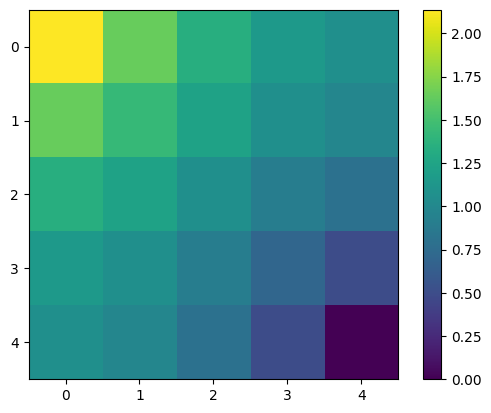

In [8]:
x = np.linalg.solve((A.T @ K @ A)[:-1,:-1], b[:-1]) # ground the bottom right node at 0
x = np.append(x, [0])
X = np.reshape(x, (nx,ny))
plt.imshow(X)
plt.colorbar()

As expected we get a linear gradient as all the contact resisances are the same.